### Ядерная оценка плотности распределения KDE

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
# сгенерируем данные на основе 2 нормальных распределений
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f*N):] += 5
    return x
x = make_data(1000)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


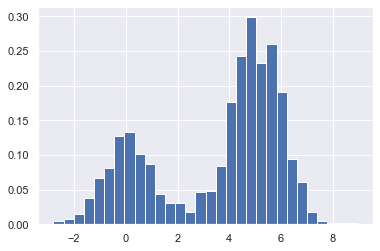

In [4]:
hist = plt.hist(x, bins=30, normed=True);

In [6]:
# общая площадь под гистограммой равна 1 (т.к. normed=True дает нормализованную гистограмму плотности распределения)
density, bins, patches = hist
widts = bins[1:] - bins[:-1]
(density * widts).sum()

1.0

In [7]:
# применьшей выборке картина может выглядеть иначе на гистограмме
x = make_data(20)
bins = np.linspace(-5,10, 10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


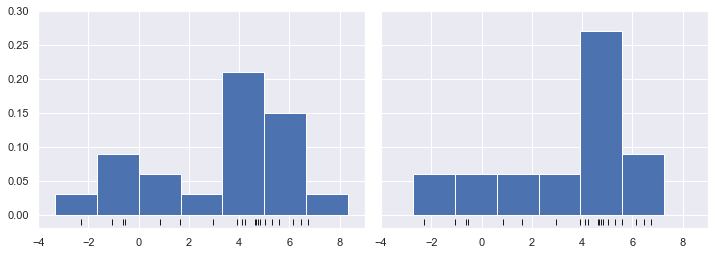

In [27]:
fig, ax = plt.subplots(1,2, figsize=(12,4),
                      sharex=True, sharey=True,
                      subplot_kw=dict(xlim=(-4,9), ylim=(-0.02, 0.3)))
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, normed=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
              markeredgewidth=1);

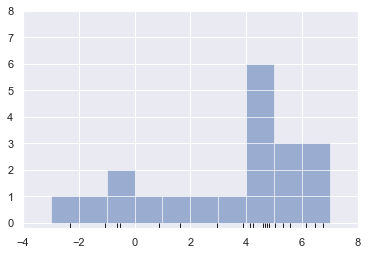

In [28]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k', #np.full_like - Return a full array with the same shape and type as a given array.
       markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                  alpha=0.5))
    ax.set_xlim(-4, 8)
    ax.set_ylim(-0.2, 8);

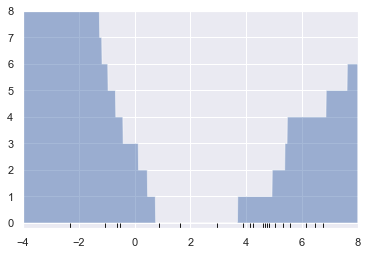

In [39]:
x_d = np.linspace(-4, 8, 1000)
density = sum( (abs(xi-x_d) > 6) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.axis([-4, 8, -0.2, 8]);

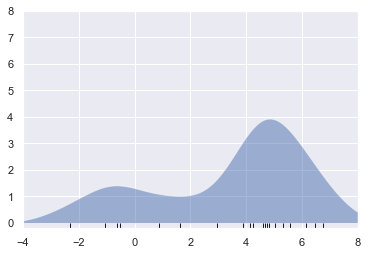

In [40]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.axis([-4, 8, -0.2, 8]);

#### Пример из практики

(-0.02, 0.22)

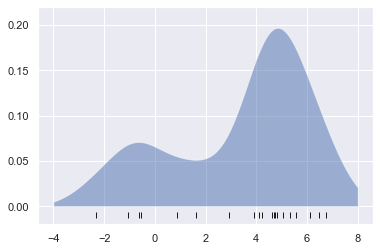

In [44]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=1.0, kernel='gaussian') # bandwidth - ширина ядра
kde.fit(x[:,None])

# score samples возвращает логарифм плотности распределения вероятности
logprob = kde.score_samples(x_d[:,None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

In [45]:
# подберем ширину ядра
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

In [49]:
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                   {'bandwidth':bandwidths}, cv=LeaveOneOut())
grid.fit(x[:,None])

GridSearchCV(cv=LeaveOneOut(), error_score='raise-deprecating',
             estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0,
                                     breadth_first=True, kernel='gaussian',
                                     leaf_size=40, metric='euclidean',
                                     metric_params=None, rtol=0),
             iid='warn', n_jobs=None,
             param_grid={'bandwidth': array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848...
        3.27454916,  3.43046929,  3.59381366,  3.76493581,  3.94420606,
        4.1320124 ,  4.32876128,  4.53487851,  4.75081016,  4.97702356,
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             

In [50]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

(-0.02, 0.22)

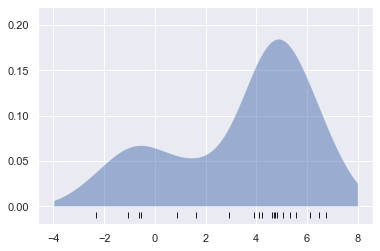

In [62]:
kde = KernelDensity(bandwidth=1.1233240329780276, kernel='gaussian') # bandwidth - ширина ядра
kde.fit(x[:,None])

# score samples возвращает логарифм плотности распределения вероятности
logprob = kde.score_samples(x_d[:,None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

#### Пример: не столь наивный Байес

In [63]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KDEClassifier(BaseEstimator, ClassifierMixin):            
    """Байесовская порождающая классификация на основе метода KDE 
            Параметры            
            ---------            
            bandwidth : float                
            Ширина ядра в каждом классе            
            kernel : str                
            Название ядра, передаваемое функции KernelDensity           
            """            
    def __init__(self, bandwidth=1.0, kernel='gaussian'):                
        self.bandwidth = bandwidth                
        self.kernel = kernel
    def fit(self, X, y):                
        self.classes_ = np.sort(np.unique(y))                
        training_sets = [X[y == yi] for yi in self.classes_]                
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,                                              
                                      kernel=self.kernel).fit(Xi)                                
                        for Xi in training_sets]                
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])                                   
                           for Xi in training_sets]                
        return self
    def predict_proba(self, X):                
        logprobs = np.array([model.score_samples(X)                                     
                             for model in self.models_]).T                
        result = np.exp(logprobs + self.logpriors_)                
        return result / result.sum(1, keepdims=True)
    
    def predict(self, X):                
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [69]:
from sklearn.datasets import load_digits        
digits = load_digits()
bandwidths = 10 ** np.linspace(0, 2, 100)        
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})        
grid.fit(digits.data, digits.target)        


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KDEClassifier(bandwidth=1.0, kernel='gaussian'),
             iid='warn', n_jobs=None,
             param_grid={'bandwidth': array([  1.        ,   1.04761575,   1.09749877,   1.149757  ,
         1.20450354,   1.26185688,   1.32194115,   1.38488637,
         1.45082878,   1.51991108,   1.59228279,   1.66810054,
         1.7475284 ,   1.83073828,   1.91791026,   2.009233  ,
         2.10490414,   2.20513074...
        34.30469286,  35.93813664,  37.64935807,  39.44206059,
        41.320124  ,  43.28761281,  45.34878508,  47.50810162,
        49.77023564,  52.14008288,  54.62277218,  57.22367659,
        59.94842503,  62.80291442,  65.79332247,  68.92612104,
        72.20809018,  75.64633276,  79.24828984,  83.02175681,
        86.97490026,  91.11627561,  95.45484567, 100.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [83]:
scores = [val for val in list(grid.cv_results_.values())[0]] 

In [80]:
list(grid.cv_results_.values())[0]

array([0.00400098, 0.00467205, 0.00367165, 0.00400019, 0.00300129,
       0.00366696, 0.00333365, 0.00266679, 0.00300924, 0.00266663,
       0.00300463, 0.002666  , 0.00333023, 0.00333031, 0.00333492,
       0.00266751, 0.0030005 , 0.00233316, 0.0030005 , 0.00300431,
       0.00300272, 0.00300058, 0.0033342 , 0.00300566, 0.00300368,
       0.00266703, 0.00266727, 0.00266759, 0.00300074, 0.00332967,
       0.00466681, 0.00400106, 0.00300129, 0.00233404, 0.0036664 ,
       0.00333802, 0.00366592, 0.00367037, 0.00266719, 0.00299986,
       0.00399963, 0.00399884, 0.00266735, 0.00332793, 0.00333301,
       0.00299565, 0.00300304, 0.00233444, 0.00300082, 0.00333389,
       0.00333484, 0.00366743, 0.00399613, 0.0033373 , 0.00466657,
       0.00333818, 0.00400106, 0.00266782, 0.00300392, 0.00299962,
       0.00266695, 0.00300074, 0.00266695, 0.00300034, 0.00333484,
       0.00300018, 0.0036672 , 0.00400368, 0.00333508, 0.00433318,
       0.00300431, 0.00300074, 0.00266798, 0.00333325, 0.00333

In [ ]:
grid.cv_results_

{'bandwidth': 7.054802310718643}
accuracy = 0.9666110183639399


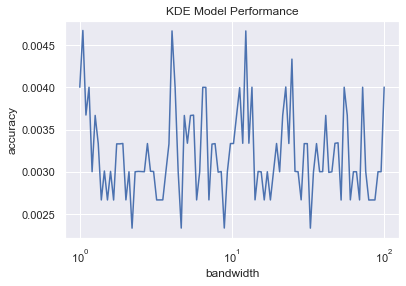

In [84]:
plt.semilogx(bandwidths, scores)        
plt.xlabel('bandwidth')            # Ширина ядра        
plt.ylabel('accuracy')             # Точность        
plt.title('KDE Model Performance') # Эффективность модели KDE
print(grid.best_params_)        
print('accuracy =', grid.best_score_)


In [86]:
from sklearn.naive_bayes import GaussianNB        
from sklearn.model_selection import cross_val_score        
cross_val_score(GaussianNB(), digits.data, digits.target).mean()


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8186003803550138

### Конвейер распознавания лиц

### HOG

In [88]:
from skimage import data, color, feature
import skimage.data

Text(0.5, 1.0, 'Визуализация HOG-признаков')

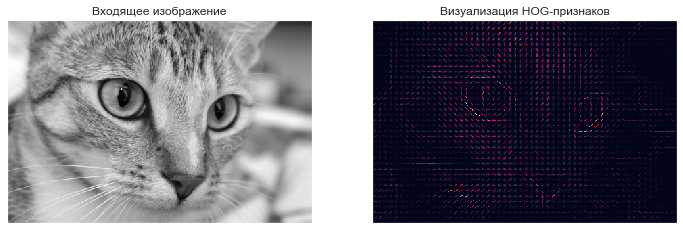

In [90]:
image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualise=True)

fig, ax = plt.subplots(1,2, figsize=(12,6),
                      subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Входящее изображение')
ax[1].imshow(hog_vis)
ax[1].set_title('Визуализация HOG-признаков')

#### Простой детектор лиц на основе HOG

In [92]:
# 1. получаем набор положительных обучающих выборок
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [93]:
# 2. получаем набор отрицательных обучающих выборок
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',                      
                'page', 'clock', 'immunohistochemistry',                      
                'chelsea', 'coffee', 'hubble_deep_field']       
images = [color.rgb2gray(getattr(data, name)())                 
          for name in imgs_to_use]


In [95]:
from sklearn.feature_extraction.image import PatchExtractor
def extract_patches(img, N, scale=1.0,                    
                    patch_size=positive_patches[0].shape):    
    extracted_patch_size = \
    tuple((scale * np.array(patch_size)).astype(int))    
    extractor = PatchExtractor(patch_size=extracted_patch_size,                               
                               max_patches=N, random_state=0)    
    patches = extractor.transform(img[np.newaxis])    
    if scale != 1:        
        patches = np.array([transform.resize(patch, patch_size)                            
                            for patch in patches])    
    return patches

In [96]:
negative_patches = np.vstack([extract_patches(im, 1000, scale) 
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

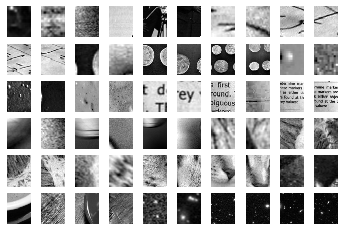

In [97]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):           
    axi.imshow(negative_patches[500 * i], cmap='gray')           
    axi.axis('off')

In [99]:
# 3. объединяем наборы и выделяем HOG-признаки
from itertools import chain
X_train = np.array([feature.hog(im)
                   for im in chain(positive_patches,
                                  negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [100]:
X_train.shape

(43233, 1215)

In [101]:
# 4. обучаем SVM
# для начала попробуем наивный байесовский классификатор для сравнения
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.95385469, 0.97349247, 0.97501908])

In [102]:
from sklearn.svm import LinearSVC
grid = GridSearchCV(LinearSVC(), {'C':[1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the numb

0.9891749358129207

In [103]:
grid.best_params_

{'C': 1.0}

In [105]:
# обучим оптимальный оцениватель на данных
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


(-0.5, 139.5, 159.5, -0.5)

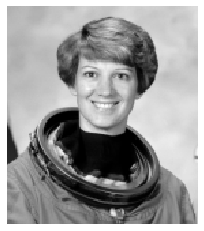

In [106]:
# 5. Выполняем поиск лиц в новои изображении
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off')

In [116]:
# создаем бегущее окно
def sliding_window(img, patch_size=positive_patches[0].shape,                           
                   istep=2, jstep=2, scale=1.0):            
    Ni, Nj = (int(scale * s) for s in patch_size)            
    for i in range(0, img.shape[0] - Ni, istep):                
        for j in range(0, img.shape[1] - Ni, jstep):                    
            patch = img[i:i + Ni, j:j + Nj]                    
            if scale != 1:                        
                patch = transform.resize(patch, patch_size)                    
            yield (i, j), patch

In [117]:
indices, patches = zip(*sliding_window(test_image))        
patches_hog = np.array([feature.hog(patch) for patch in patches])        
patches_hog.shape

(1911, 1215)

In [118]:
labels = model.predict(patches_hog)
labels.sum()

49.0

In [119]:
# среди 1911 фотографий найдено 49 лиц

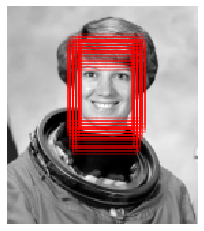

In [120]:
fig, ax = plt.subplots()        
ax.imshow(test_image, cmap='gray')
ax.axis('off')
Ni, Nj = positive_patches[0].shape        
indices = np.array(indices)
for i, j in indices[labels == 1]:            
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',                                       
                               alpha=0.3, lw=2,                                       
                               facecolor='none'))
